In [1]:
# =============================================================================
# ATLAS v3 - COI PIPELINE - SETUP AND DATA LOADING
# =============================================================================
#
# OBJECTIVE:
#   To set up the environment for COI model training and load all
#   pre-processed data artifacts from disk.
#
# WORKFLOW:
#   1.  Import all necessary libraries.
#   2.  Set up the project's root path.
#   3.  Verify that TensorFlow can detect and utilize the GPU.
#   4.  Define the file paths for the COI-specific artifacts.
#   5.  Load the training data, testing data, and the label encoder.
#   6.  Print a summary of the loaded data shapes for verification.
#
# =============================================================================

# --- Imports ---
import numpy as np
import tensorflow as tf
from scipy.sparse import load_npz
import pickle
from pathlib import Path
import sys

# --- Setup Project Path ---
project_root = Path.cwd().parent

# --- 1. Verification Step: Check for GPU ---
print("--- TensorFlow Setup ---")
print(f"TensorFlow Version: {tf.__version__}")
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU detected: {gpu_devices[0]}")
else:
    print("WARNING: No GPU detected. TensorFlow will run on CPU.")
print("-" * 26)

# --- 2. Define COI-specific file paths ---
PROCESSED_DATA_DIR = project_root / "data" / "processed"
MODELS_DIR = project_root / "models"

X_TRAIN_PATH = PROCESSED_DATA_DIR / "X_train_coi.npz"
X_TEST_PATH = PROCESSED_DATA_DIR / "X_test_coi.npz"
Y_TRAIN_PATH = PROCESSED_DATA_DIR / "y_train_coi.npy"
Y_TEST_PATH = PROCESSED_DATA_DIR / "y_test_coi.npy"

LABEL_ENCODER_PATH = MODELS_DIR / "coi_genus_label_encoder.pkl"

# --- 3. Load the data and encoders ---
print("\n--- Loading COI Data ---")
X_train = load_npz(X_TRAIN_PATH)
X_test = load_npz(X_TEST_PATH)
y_train = np.load(Y_TRAIN_PATH)
y_test = np.load(Y_TEST_PATH)

with open(LABEL_ENCODER_PATH, 'rb') as f:
    label_encoder = pickle.load(f)
print("Data loading complete.")

# --- 4. Verification Step ---
print("\n--- Loaded Data Shapes ---")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print("-" * 30)
print(f"Shape of X_test:  {X_test.shape}")
print(f"Shape of y_test:  {y_test.shape}")
print(f"Number of classes (genera): {len(label_encoder.classes_)}")

--- TensorFlow Setup ---
TensorFlow Version: 2.10.1
GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
--------------------------

--- Loading COI Data ---
Data loading complete.

--- Loaded Data Shapes ---
Shape of X_train: (7916, 41040)
Shape of y_train: (7916,)
------------------------------
Shape of X_test:  (1980, 41040)
Shape of y_test:  (1980,)
Number of classes (genera): 111


In [2]:
# =============================================================================
# STEP 2: DEFINE AND TRAIN THE COI MODEL
# =============================================================================
#
# OBJECTIVE:
#   To define the neural network architecture, train it on the prepared COI
#   data, and save the resulting model artifact.
#
# WORKFLOW:
#   1.  Define the Keras Sequential model architecture, dynamically sized to
#       the input features and output classes of the COI dataset.
#   2.  Perform a pre-flight check on the training data to ensure there are no
#       "singleton" classes, which would cause errors during validation splitting.
#   3.  Instantiate the custom callback for clean, single-line training progress.
#   4.  Execute the training using `model.fit()`, with an EarlyStopping
#       callback to prevent overfitting and save time.
#   5.  Immediately save the best version of the trained model to disk.
#
# =============================================================================

# --- Imports for this cell ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split

# --- PART 1: Define and Compile Model ---
print("--- Defining COI Model Architecture ---")
num_classes = len(label_encoder.classes_)
input_shape = X_train.shape[1]

model = Sequential([
    Dense(2048, activation='relu', input_shape=(input_shape,)),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


# --- PART 2: Prepare Data and Train ---
print("\n--- Preparing Data and Starting Training ---")

# Pre-flight check for singletons in the training set
unique, counts = np.unique(y_train, return_counts=True)
if np.min(counts) < 2:
    print("WARNING: Singletons found in y_train. Cleaning...")
    non_singleton_indices = np.where(~np.isin(y_train, unique[counts < 2]))[0]
    X_train = X_train[non_singleton_indices]
    y_train = y_train[non_singleton_indices]

# Create validation set
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# Define custom callback
class TrainingProgressCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy', 0); val_acc = logs.get('val_accuracy', 0)
        loss = logs.get('loss', 0); val_loss = logs.get('val_loss', 0)
        acc_bar = '█' * int(acc * 20) + '·' * (20 - int(acc * 20))
        val_acc_bar = '█' * int(val_acc * 20) + '·' * (20 - int(val_acc * 20))
        print(f"\rEpoch {epoch+1:02d}/50 | Loss: {loss:.4f} | Acc: {acc:.2%} [{acc_bar}] | Val_Loss: {val_loss:.4f} | Val_Acc: {val_acc:.2%} [{val_acc_bar}]", end='')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)

# Start training
history = model.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=0,
    callbacks=[early_stopping, TrainingProgressCallback()]
)
print("\n\n--- Training complete. ---")


# --- PART 3: Save the Model ---
MODEL_PATH = MODELS_DIR / "coi_genus_classifier.keras"
print(f"\nSaving trained model to: {MODEL_PATH}")
model.save(MODEL_PATH)
print("Model saved successfully.")

--- Defining COI Model Architecture ---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              84051968  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 111)               113775    
                                                                 
Total params: 86,263,919
Trainable params: 86,263,919
Non-trainable params: 0
_________________________________________________________________

---

C:\Users\jampa\miniconda3\envs\atlas\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 2048), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 10/50 | Loss: 0.3468 | Acc: 96.20% [███████████████████·] | Val_Loss: 0.3123 | Val_Acc: 95.96% [███████████████████·]Restoring model weights from the end of the best epoch: 8.
Epoch 11/50 | Loss: 0.3390 | Acc: 96.22% [███████████████████·] | Val_Loss: 0.2256 | Val_Acc: 96.34% [███████████████████·]Epoch 11: early stopping


--- Training complete. ---

Saving trained model to: C:\Users\jampa\Music\atlas\models\coi_genus_classifier.keras
Model saved successfully.


--- Starting Post-Training Workflow ---
Clearing TensorFlow session and running garbage collection...
Memory cleared successfully.

Loading model from: C:\Users\jampa\Music\atlas\models\coi_genus_classifier.keras
Model loaded successfully.

Loading test data...
Test data loaded successfully.

Evaluating model on the test set...
62/62 [==============================] - 1s 15ms/step - loss: 0.3022 - accuracy: 0.9677

--- Final COI Model Evaluation ---
Test Set Loss:     0.3022
Test Set Accuracy: 96.77%
--------------------------------

--- Generating Training History Plots ---


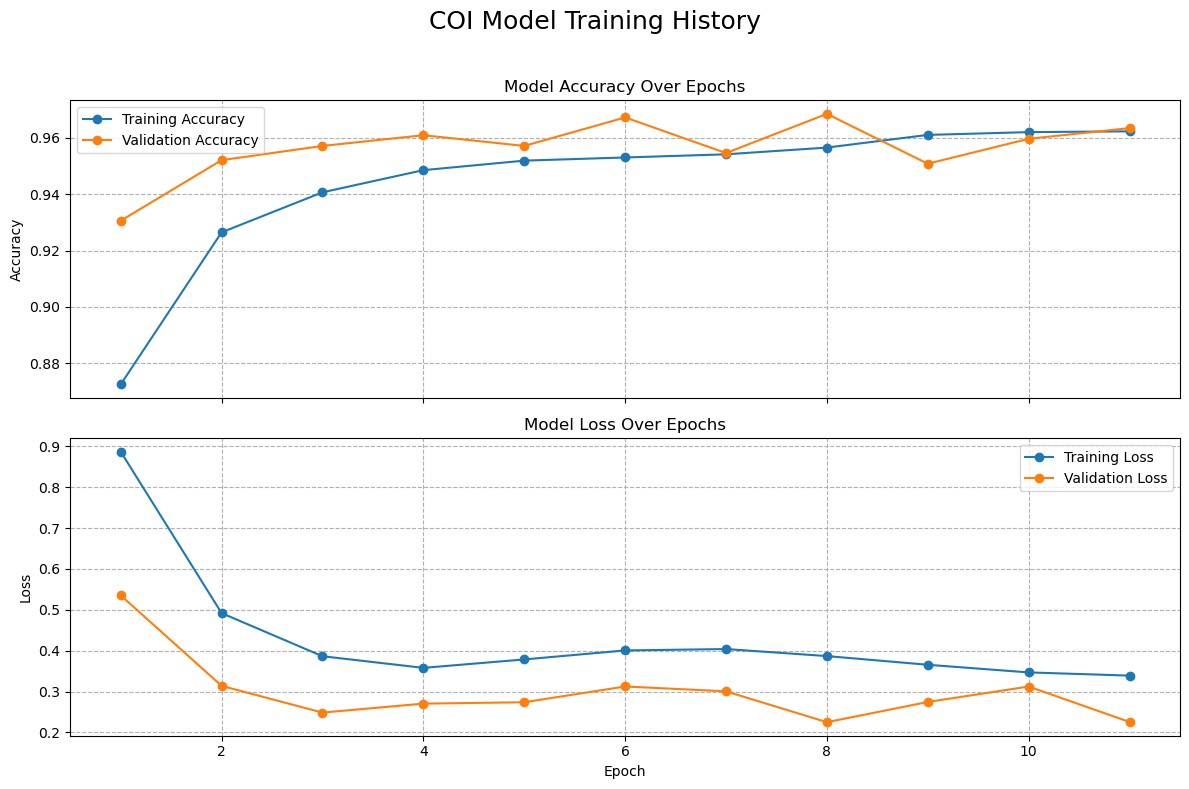

In [3]:
# =============================================================================
# STEP 3: FINAL MODEL EVALUATION AND VISUALIZATION
# =============================================================================
#
# OBJECTIVE:
#   To perform a definitive, unbiased evaluation of the trained COI model on
#   the unseen test set. This provides the final "report card" for this model.
#
# WORKFLOW:
#   1.  Proactively clear system memory to ensure a stable evaluation environment.
#   2.  Load the saved model and the corresponding test data from their files.
#   3.  Run `model.evaluate()` on the test set to get the final accuracy score.
#   4.  Attempt to plot the training history for visual analysis, gracefully
#       handling the case where the kernel may have been restarted.
#
# =============================================================================

# --- Imports for this cell ---
import tensorflow as tf
import gc
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.sparse import load_npz
import numpy as np

# --- Define all necessary file paths ---
project_root = Path.cwd().parent
MODELS_DIR = project_root / "models"
PROCESSED_DATA_DIR = project_root / "data" / "processed"

MODEL_PATH = MODELS_DIR / "coi_genus_classifier.keras"
X_TEST_PATH = PROCESSED_DATA_DIR / "X_test_coi.npz"
Y_TEST_PATH = PROCESSED_DATA_DIR / "y_test_coi.npy"

# --- 1. Clean up memory ---
print("--- Starting Post-Training Workflow ---")
print("Clearing TensorFlow session and running garbage collection...")
tf.keras.backend.clear_session()
gc.collect()
print("Memory cleared successfully.")

# --- 2. Load model and test data ---
print(f"\nLoading model from: {MODEL_PATH}")
loaded_model = load_model(MODEL_PATH)
print("Model loaded successfully.")

print(f"\nLoading test data...")
X_test = load_npz(X_TEST_PATH)
y_test = np.load(Y_TEST_PATH)
print("Test data loaded successfully.")

# --- 3. Evaluate the model ---
print("\nEvaluating model on the test set...")
loss, accuracy = loaded_model.evaluate(X_test, y_test, verbose=1)

print("\n--- Final COI Model Evaluation ---")
print(f"Test Set Loss:     {loss:.4f}")
print(f"Test Set Accuracy: {accuracy:.2%}")
print("--------------------------------\n")

# --- 4. Visualize training history (if possible) ---
try:
    print("--- Generating Training History Plots ---")
    history_df = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle('COI Model Training History', fontsize=18)

    # Plot Accuracy
    ax1.plot(history_df.index + 1, history_df['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history_df.index + 1, history_df['val_accuracy'], label='Validation Accuracy', marker='o')
    ax1.set_title('Model Accuracy Over Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, linestyle='--')

    # Plot Loss
    ax2.plot(history_df.index + 1, history_df['loss'], label='Training Loss', marker='o')
    ax2.plot(history_df.index + 1, history_df['val_loss'], label='Validation Loss', marker='o')
    ax2.set_title('Model Loss Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, linestyle='--')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

except NameError:
    print("\nCould not generate plots because the 'history' object was not found in memory.")
    print("This is expected if the kernel was restarted after training.")